# Cats vs Dogs

 Train a convolutional neural network to classify an image
into one of two classes: "cat" or "dog". The code for the neural networks
you train will be written for you, and you are not (yet!) expected
to understand all provided code.

1. Understand at a high level the training loop for a machine learning model.
2. Understand the distinction between training, validation, and test data.
3. The concepts of overfitting and underfitting.
4. Investigate how different hyperparameters, such as learning rate and batch size, affect the success of training.
5. Compare an ANN (aka Multi-Layer Perceptron) with a CNN.


## Colab Link

Include a link to your colab file here

Colab Link: https://colab.research.google.com/drive/1h5C4Cctgq9WCBA24exjGN7o5elEt-Hui?usp=sharing

In [ ]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms


## Part 0. Helper Functions

We will be making use of the following helper functions. You will be asked to look
at and possibly modify some of these, but you are not expected to understand all of them.

You should look at the function names and read the docstrings. If you are curious, come back and explore the code *after* making some progress on the lab.

In [ ]:
###############################################################################
# Data Loading

def get_relevant_indices(dataset, classes, target_classes):
    """ Return the indices for datapoints in the dataset that belongs to the
    desired target classes, a subset of all possible classes.

    Args:
        dataset: Dataset object
        classes: A list of strings denoting the name of each class
        target_classes: A list of strings denoting the name of desired classes
                        Should be a subset of the 'classes'
    Returns:
        indices: list of indices that have labels corresponding to one of the
                 target classes
    """
    indices = []
    for i in range(len(dataset)):
        # Check if the label is in the target classes
        label_index = dataset[i][1] # ex: 3
        label_class = classes[label_index] # ex: 'cat'
        if label_class in target_classes:
            indices.append(i)
    return indices

def get_data_loader(target_classes, batch_size):
    """ Loads images of cats and dogs, splits the data into training, validation
    and testing datasets. Returns data loaders for the three preprocessed datasets.

    Args:
        target_classes: A list of strings denoting the name of the desired
                        classes. Should be a subset of the argument 'classes'
        batch_size: A int representing the number of samples per batch

    Returns:
        train_loader: iterable training dataset organized according to batch size
        val_loader: iterable validation dataset organized according to batch size
        test_loader: iterable testing dataset organized according to batch size
        classes: A list of strings denoting the name of each class
    """

    classes = ('plane', 'car', 'bird', 'cat',
               'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    ########################################################################
    # The output of torchvision datasets are PILImage images of range [0, 1].
    # We transform them to Tensors of normalized range [-1, 1].
    transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    # Load CIFAR10 training data
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform)
    # Get the list of indices to sample from
    relevant_indices = get_relevant_indices(trainset, classes, target_classes)

    # Split into train and validation
    np.random.seed(1000) # Fixed numpy random seed for reproducible shuffling
    np.random.shuffle(relevant_indices)
    split = int(len(relevant_indices) * 0.8) #split at 80%

    # split into training and validation indices
    relevant_train_indices, relevant_val_indices = relevant_indices[:split], relevant_indices[split:]
    train_sampler = SubsetRandomSampler(relevant_train_indices)
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                               num_workers=1, sampler=train_sampler)
    val_sampler = SubsetRandomSampler(relevant_val_indices)
    val_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              num_workers=1, sampler=val_sampler)
    # Load CIFAR10 testing data
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform)
    # Get the list of indices to sample from
    relevant_test_indices = get_relevant_indices(testset, classes, target_classes)
    test_sampler = SubsetRandomSampler(relevant_test_indices)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                             num_workers=1, sampler=test_sampler)
    return train_loader, val_loader, test_loader, classes

###############################################################################
# Training
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

def normalize_label(labels):
    """
    Given a tensor containing 2 possible values, normalize this to 0/1

    Args:
        labels: a 1D tensor containing two possible scalar values
    Returns:
        A tensor normalize to 0/1 value
    """
    max_val = torch.max(labels)
    min_val = torch.min(labels)
    norm_labels = (labels - min_val)/(max_val - min_val)
    return norm_labels

def evaluate(net, loader, criterion):
    """ Evaluate the network on the validation set.

     Args:
         net: PyTorch neural network object
         loader: PyTorch data loader for the validation set
         criterion: The loss function
     Returns:
         err: A scalar for the avg classification error over the validation set
         loss: A scalar for the average loss function over the validation set
     """
    total_loss = 0.0
    total_err = 0.0
    total_epoch = 0
    for i, data in enumerate(loader, 0):
        inputs, labels = data
        labels = normalize_label(labels)  # Convert labels to 0/1
        outputs = net(inputs)
        loss = criterion(outputs, labels.float())
        corr = (outputs > 0.0).squeeze().long() != labels
        total_err += int(corr.sum())
        total_loss += loss.item()
        total_epoch += len(labels)
    err = float(total_err) / total_epoch
    loss = float(total_loss) / (i + 1)
    return err, loss

###############################################################################
# Training Curve
def plot_training_curve(path):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation error/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    import matplotlib.pyplot as plt
    train_err = np.loadtxt("{}_train_err.csv".format(path))
    val_err = np.loadtxt("{}_val_err.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Error")
    n = len(train_err) # number of epochs
    plt.plot(range(1,n+1), train_err, label="Train")
    plt.plot(range(1,n+1), val_err, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

## Part 1. Visualizing the Data [7 pt]

We will make use of some of the CIFAR-10 data set, which consists of
colour images of size 32x32 pixels belonging to 10 categories. You can
find out more about the dataset at https://www.cs.toronto.edu/~kriz/cifar.html

For this assignment, we will only be using the cat and dog categories.
We have included code that automatically downloads the dataset the
first time that the main script is run.

In [ ]:
# This will download the CIFAR-10 dataset to a folder called "data"
# the first time you run this code.
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"],
    batch_size=1) # One image per batch

100%|██████████| 170498071/170498071 [00:02<00:00, 73089872.51it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


### Part (a) -- 1 pt

Visualize some of the data by running the code below.
Include the visualization in your writeup.

(You don't need to submit anything else.)

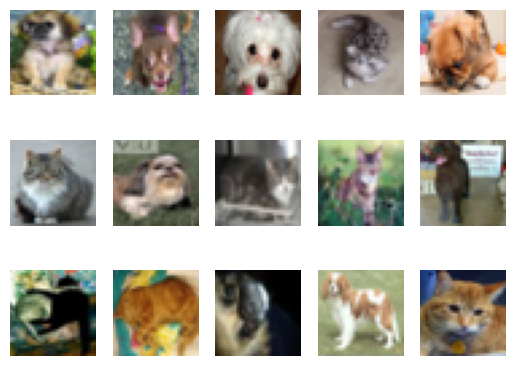

In [ ]:
import matplotlib.pyplot as plt

k = 0
for images, labels in train_loader:
    # since batch_size = 1, there is only 1 image in `images`
    image = images[0]
    #images is torch.Size([1, 3, 32, 32])
    # print(image.size()) is [3, 32, 32])

    # place the colour channel at the end, instead of at the beginning
    img = np.transpose(image, [1,2,0])
    #print(img.size()) #[32, 32, 3])
    # normalize pixel intensity values to [0, 1]
    img = img / 2 + 0.5
    plt.subplot(3, 5, k+1)
    plt.axis('off')
    plt.imshow(img)

    k += 1
    if k > 14: # 0 to 14 (total 15 images)
        break

### Part (b) -- 3 pt

How many training examples do we have for the combined `cat` and `dog` classes?
What about validation examples?
What about test examples?

In [ ]:
# from the CIFAR dataset website label 3 == "cats" and class label of 5 corresponds to "dogs"
'''
testing purposes to find out the class lables.
for images, labels in train_loader:
  print(labels) tensors of 3 and 5 are given
getting the value of the tensor
print(torch.tensor(5))
print(torch.tensor(5).item())
'''
class3TrainAmount = 0
class3ValAmount = 0
class3TestAmount = 0
none = 0
class5TrainAmount = 0
class5ValAmount = 0
class5TestAmount = 0
for images,labels in train_loader:
  if (labels.item() == 3):
    class3TrainAmount+=1
  elif (labels.item() == 5):
    class5TrainAmount+= 1
  else:
    none+=1

for images,labels in val_loader:
  if (labels.item() == 3):
    class3ValAmount+=1
  elif (labels.item() == 5):
    class5ValAmount+= 1


for images,labels in test_loader:
  if (labels.item() == 3):
    class3TestAmount+=1
  elif (labels.item() == 5):
    class5TestAmount+= 1



In [ ]:
print("      Train | Val    | test Count")
print("Cats: ", class3TrainAmount,"| ",class3ValAmount ,"  | ",class3TestAmount)
print("Dogs:", class5TrainAmount," | ", class5ValAmount," | ", class5TestAmount)

      Train | Val    | test Count
Cats:  4018 |  982   |  1000
Dogs: 3982  |  1018  |  1000


### Part (c) -- 3pt

Why do we need a validation set when training our model? What happens if we judge the
performance of our models using the training set loss/error instead of the validation
set loss/error?

A validation set is necessary when training the model because simply relying on the training data may lead to overfitting.
Validation set may use to evaluate the performance on data that hasn't been shown during the training phase. It can provide a good estimate to how it may perform with new data for the testing phase.

For example, as hyperparamters are tuned and as number of iterations increase, the training accuracy may increase significantly and eventually plateau (training loss may decrease).

However,  during phase of high training accuracy, validation accuracy may start to decrease (validation loss may increase).Thus, the model may overfit to the specific training data. This memorization behavior of the model leads to higher validation losses when it encounters new data.
Therefore when we judge the performance based on only training error, chances of overfitting are larger. Validation loss should be used to predict overfitting. For example, initially the validation loss slowly decreases but when the validation loss starts to increase, the model is being overfitted.

## Part 2. Training [15 pt]

We define two neural networks, a `LargeNet` and `SmallNet`.
We'll be training the networks in this section.

You won't understand fully what these networks are doing until
the next few classes, and that's okay. For this assignment, please
focus on learning how to train networks, and how hyperparameters affect
training.

In [ ]:
class LargeNet(nn.Module):
    def __init__(self):
        super(LargeNet, self).__init__()
        self.name = "large"
        self.conv1 = nn.Conv2d(3, 5, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(5, 10, 5)
        self.fc1 = nn.Linear(10 * 5 * 5, 32)
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 10 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [ ]:
class SmallNet(nn.Module):
    def __init__(self):
        super(SmallNet, self).__init__()
        self.name = "small"
        self.conv = nn.Conv2d(3, 5, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc = nn.Linear(5 * 7 * 7, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv(x)))
        x = self.pool(x)
        x = x.view(-1, 5 * 7 * 7)
        x = self.fc(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [ ]:
small_net = SmallNet()
large_net = LargeNet()
print(small_net)
print(large_net)

SmallNet(
  (conv): Conv2d(3, 5, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=245, out_features=1, bias=True)
)
LargeNet(
  (conv1): Conv2d(3, 5, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(5, 10, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=250, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=1, bias=True)
)


### Part (a) -- 2pt

The methods `small_net.parameters()` and `large_net.parameters()`
produces an iterator of all the trainable parameters of the network.
These parameters are torch tensors containing many scalar values.

We haven't learned how how the parameters in these high-dimensional
tensors will be used, but we should be able to count the number
of parameters. Measuring the number of parameters in a network is
one way of measuring the "size" of a network.

What is the total number of parameters in `small_net` and in
`large_net`? (Hint: how many numbers are in each tensor?)

In [ ]:
'''
for param in small_net.parameters():
    #print(param)
    print(param.shape)
# total elements in torch 1 + total elements in torch 2
'''

totalElementsInTensorSmallNet = 0
#torch.numel finds total elements in each tensor
for param in small_net.parameters():
  totalElementsInTensorSmallNet+= torch.numel(param)


totalElementsInTensorLargeNet = 0

for param in large_net.parameters():
  totalElementsInTensorLargeNet+=torch.numel(param)
print("Small Net Parameters:", totalElementsInTensorSmallNet)
print("Large Net Paramters: ",totalElementsInTensorLargeNet)

Small Net Parameters: 386
Large Net Paramters:  9705


### The function train_net

The function `train_net` below takes an untrained neural network (like `small_net` and `large_net`) and
several other parameters. You should be able to understand how this function works.
The figure below shows the high level training loop for a machine learning model:

![alt text](https://github.com/UTNeural/Lab2/blob/master/Diagram.png?raw=true)

In [ ]:
def train_net(net, batch_size=64, learning_rate=0.01, num_epochs=30):
    ########################################################################
    # Train a classifier on cats vs dogs
    target_classes = ["cat", "dog"]
    ########################################################################
    # Fixed PyTorch random seed for reproducible result
    torch.manual_seed(1000)
    ########################################################################
    # Obtain the PyTorch data loader objects to load batches of the datasets
    train_loader, val_loader, test_loader, classes = get_data_loader(
            target_classes, batch_size)
    ########################################################################
    # Define the Loss function and optimizer
    # The loss function will be Binary Cross Entropy (BCE). In this case we
    # will use the BCEWithLogitsLoss which takes unnormalized output from
    # the neural network and scalar label.
    # Optimizer will be SGD with Momentum.
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    ########################################################################
    # Set up some numpy arrays to store the training/test loss/erruracy
    train_err = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_err = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    ########################################################################
    # Train the network
    # Loop over the data iterator and sample a new batch of training data
    # Get the output from the network, and optimize our loss function.
    start_time = time.time()
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        total_train_loss = 0.0
        total_train_err = 0.0
        total_epoch = 0
        for i, data in enumerate(train_loader, 0): # index 0 = batch #0 start from batch #0 etc
        #enumerate also accounts for index
            # Get the inputs
            inputs, labels = data
            labels = normalize_label(labels) # Convert labels to 0/1
            # Zero the parameter gradients
            optimizer.zero_grad()
            # Forward pass, backward pass, and optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels.float())
            loss.backward()
            optimizer.step()
            # Calculate the statistics
            corr = (outputs > 0.0).squeeze().long() != labels
            total_train_err += int(corr.sum())
            total_train_loss += loss.item()
            total_epoch += len(labels)
        train_err[epoch] = float(total_train_err) / total_epoch
        train_loss[epoch] = float(total_train_loss) / (i+1)
        val_err[epoch], val_loss[epoch] = evaluate(net, val_loader, criterion)
        print(("Epoch {}: Train err: {}, Train loss: {} |"+
               "Validation err: {}, Validation loss: {}").format(
                   epoch + 1,
                   train_err[epoch],
                   train_loss[epoch],
                   val_err[epoch],
                   val_loss[epoch]))
        # Save the current model (checkpoint) to a file
        model_path = get_model_name(net.name, batch_size, learning_rate, epoch)
        torch.save(net.state_dict(), model_path)

    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))
    # Write the train/test loss/err into CSV file for plotting later
    epochs = np.arange(1, num_epochs + 1)
    np.savetxt("{}_train_err.csv".format(model_path), train_err)
    np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt("{}_val_err.csv".format(model_path), val_err)
    np.savetxt("{}_val_loss.csv".format(model_path), val_loss)

### Part (b) -- 1pt

The parameters to the function `train_net` are hyperparameters of our neural network.
We made these hyperparameters easy to modify so that we can tune them later on.

What are the default values of the parameters `batch_size`, `learning_rate`,
and `num_epochs`?

The default values: batch_size is 64, learning_rate is 0.01, num_epochs is 30

### Part (c) -- 3 pt

What files are written to disk when we call `train_net` with `small_net`, and train for 5 epochs? Provide a list
of all the files written to disk, and what information the files contain.

There are CSV files written to the disk that start with model_path and end with the corresponding suffix.

train_error[epoch] consists of the training error at a speicifc epoch index . but train_error is able to access information about all train_error for all epochs as an array.

  * model_path_train_err.csv has information about train_error for all epochs
  * model_path_train_loss.csv has information about train_loss for all epochs
  * model_path_val_err.csv has information about val_err for all epochs
  * model_path_val_loss.csv has information about val_loss for all epochs

  A model checkpoint for each epoch is also written

In [ ]:
#train_output = train_net(small_net, 64, 0.01,5)

### Part (d) -- 2pt

Train both `small_net` and `large_net` using the function `train_net` and its default parameters.
The function will write many files to disk, including a model checkpoint (saved values of model weights)
at the end of each epoch.

If you are using Google Colab, you will need to mount Google Drive
so that the files generated by `train_net` gets saved. We will be using
these files in part (d).
(See the Google Colab tutorial for more information about this.)

Report the total time elapsed when training each network. Which network took longer to train?
Why?

In [ ]:
# Since the function writes files to disk, you will need to mount
# your Google Drive. If you are working on the lab locally, you
# can comment out this code.

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
train_net(small_net)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.428875, Train loss: 0.6730601897239685 |Validation err: 0.387, Validation loss: 0.6578138209879398
Epoch 2: Train err: 0.370125, Train loss: 0.6460841841697693 |Validation err: 0.3795, Validation loss: 0.6537260729819536
Epoch 3: Train err: 0.354125, Train loss: 0.6351687178611756 |Validation err: 0.3485, Validation loss: 0.6288061160594225
Epoch 4: Train err: 0.3415, Train loss: 0.6212798862457275 |Validation err: 0.369, Validation loss: 0.6300079710781574
Epoch 5: Train err: 0.327, Train loss: 0.6106734185218811 |Validation err: 0.3355, Validation loss: 0.6188955008983612
Epoch 6: Train err: 0.315375, Train loss: 0.5980393860340119 |Validation err: 0.3395, Validation loss: 0.6153324209153652
Epoch 7: Train err: 0.310875, Train loss: 0.5896380169391632 |Validation err: 0.335, Validation loss: 0.6076379399746656
Epoch 8: Train err: 0.305125, Train loss: 0.5823498718738556 |Validation err: 

In [ ]:
train_net(large_net)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.471, Train loss: 0.6914409818649292 |Validation err: 0.4465, Validation loss: 0.6879428848624229
Epoch 2: Train err: 0.44125, Train loss: 0.6822701606750489 |Validation err: 0.432, Validation loss: 0.6897477842867374
Epoch 3: Train err: 0.402, Train loss: 0.6672421150207519 |Validation err: 0.383, Validation loss: 0.6571851503103971
Epoch 4: Train err: 0.367875, Train loss: 0.6445008797645568 |Validation err: 0.3695, Validation loss: 0.6436846144497395
Epoch 5: Train err: 0.345, Train loss: 0.6249605293273925 |Validation err: 0.334, Validation loss: 0.6227517072111368
Epoch 6: Train err: 0.3255, Train loss: 0.6057155010700226 |Validation err: 0.326, Validation loss: 0.6114812176674604
Epoch 7: Train err: 0.3225, Train loss: 0.5962850911617279 |Validation err: 0.3115, Validation loss: 0.5978807769715786
Epoch 8: Train err: 0.3055, Train loss: 0.5789266006946564 |Validation err: 0.322, Valid

In [ ]:
print("Small Net train time : 143.92 seconds")
print("Large net train time:  172.52 seconds ")

#Since LargeNet has more paramters to train and it has more convolution layers , it took longer than smallNet

Small Net train time : 143.92 seconds
Large net train time:  172.52 seconds 


### Part (e) - 2pt

Use the function `plot_training_curve` to display the trajectory of the
training/validation error and the training/validation loss.
You will need to use the function `get_model_name` to generate the
argument to the `plot_training_curve` function.

Do this for both the small network and the large network. Include both plots
in your writeup.

Small Net (Error and  Loss): 


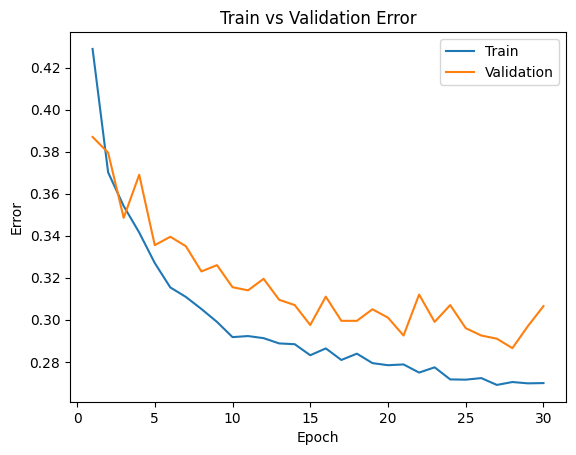

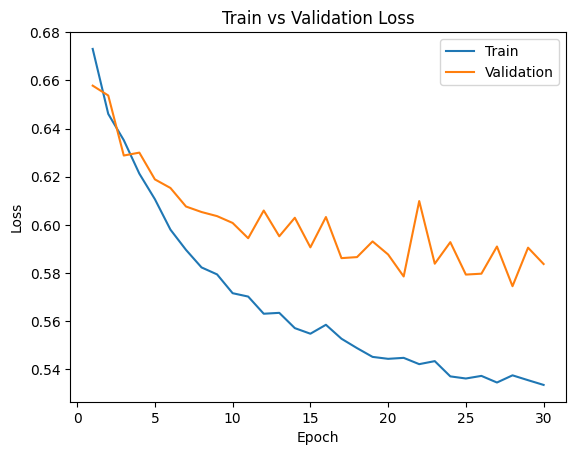

Large Net (Error and  Loss): 


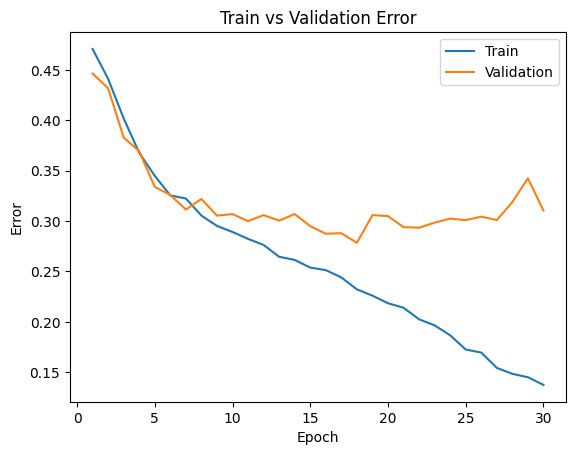

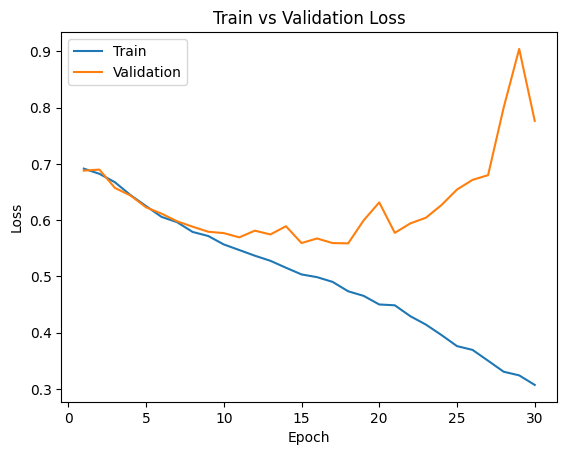

In [ ]:
#def get_model_name(name, batch_size, learning_rate, epoch):

model_path_for_small_net = get_model_name("small", batch_size=64, learning_rate=0.01, epoch=29)
model_path_for_large_net = get_model_name("large", batch_size=64, learning_rate=0.01, epoch=29)
print("Small Net (Error and  Loss): ")
plot_training_curve(model_path_for_small_net)
print("Large Net (Error and  Loss): ")
plot_training_curve(model_path_for_large_net)




### Part (f) - 5pt

Describe what you notice about the training curve.
How do the curves differ for `small_net` and `large_net`?
Identify any occurences of underfitting and overfitting.

The training curves in small_net also has more fluctuations compared to the training curves in large_net for loss and error - even though both training curves appear to decrease in the long run.

**Small Net Graphs**

In the small_net error and loss curve: training curves consistantly decreases with minor fluctuations while the validation curves after around 7 epochs starts to increase/decrease fluctuate rapidly.

The validation curve is decreasing in the long run but has a highly fluctuating behavior (unlike large_net validation curve behaviors that overall increases).

For both small_net loss and error curves:
When validation loss and error starts to increase rapidly (but training error still decreases) after epoch 10, the data has been overfitted.
However, any epochs prior to epoch 10, the data is underfitted.

* training curves (loss and error) for both small_net graphs plateaus between 20-25 epochs.

**Large Net Graphs**

In the large_net error and loss curves:
  Around 13 epochs (both error and loss) validation curves start to increase overall and there are less fluctuations compared to small_net
  
Training and validation curves diverge after epoch 13.

Since training loss/error still decreases and validation loss/error increases, overfitting happens after epoch 13.

Any epoch before epoch 13 is being underfitted.

* training curves (loss and error) for both large_net graphs steadliy decreases.



## Part 3. Optimization Parameters [12 pt]

For this section, we will work with `large_net` only.

### Part (a) - 3pt

Train `large_net` with all default parameters, except set `learning_rate=0.001`.
Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *lowering* the learning rate.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.47625, Train loss: 0.6928360004425049 |Validation err: 0.467, Validation loss: 0.6924686580896378
Epoch 2: Train err: 0.448625, Train loss: 0.6922589740753173 |Validation err: 0.4305, Validation loss: 0.6916493494063616
Epoch 3: Train err: 0.43575, Train loss: 0.6916067256927491 |Validation err: 0.4285, Validation loss: 0.6908544301986694
Epoch 4: Train err: 0.43, Train loss: 0.6908613419532776 |Validation err: 0.424, Validation loss: 0.6896595824509859
Epoch 5: Train err: 0.434125, Train loss: 0.6899194955825806 |Validation err: 0.4195, Validation loss: 0.6886935662478209
Epoch 6: Train err: 0.43575, Train loss: 0.688741192817688 |Validation err: 0.4195, Validation loss: 0.6867824867367744
Epoch 7: Train err: 0.437125, Train loss: 0.6873774199485779 |Validation err: 0.4185, Validation loss: 0.6851983051747084
Epoch 8: Train err: 0.4375, Train loss: 0.6859278454780579 |Validation err: 0.41

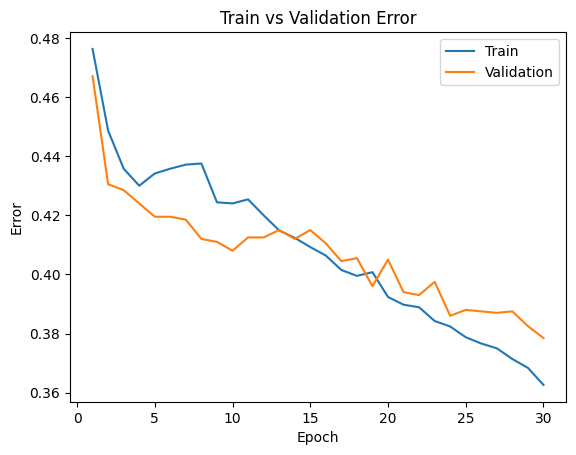

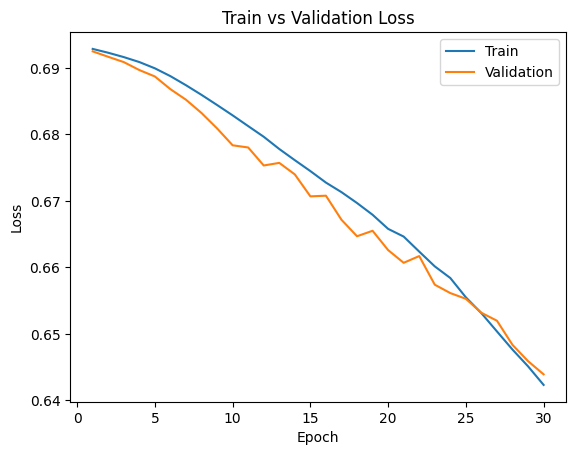

In [ ]:
# Note: When we re-construct the model, we start the training
# with *random weights*. If we omit this code, the values of
# the weights will still be the previously trained values.
large_net = LargeNet()
#train_net(large_net, learning_rate = 0.001) can also use this OR full version
#def train_net(net, batch_size=64, learning_rate=0.01, num_epochs=30):

train_net(large_net, batch_size=64, learning_rate=0.001, num_epochs=30)
model_path_for_new_large_net = get_model_name("large", batch_size=64, learning_rate=0.001, epoch=29)
print("Large Net (Error and  Loss): ")
plot_training_curve(model_path_for_new_large_net)


The model takes almost the same amount of time to train ( slightly less time to train)


 Default parameters: 172.52 seconds

 Current parameters: 167.60 seconds



Lowering learning rate:

Overfitting is reduced in with the learning rate decreased: since the training and validation loss and error decrease with the number of epochs. However, lowering the learning rate has underfit the data; For example, at 29 epochs, the Validation loss is about 0.645 compared to a lower validation loss of 0.58 (optimal stopping point before overfitting)when the learning rate was 0.01.


 A higher learning rate makes larger steps in an iteration to the most optimal paramters (via gradient descent in back propogation) which has higher chances to overfit the data if the learning rate is too large. If the learning rate is too small, there is a greater chance to underfit the data as smaller steps are taken at each epoch, taking more training iterations to reach the optimal paramters.



### Part (b) - 3pt

Train `large_net` with all default parameters, except set `learning_rate=0.1`.
Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *increasing* the learning rate.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.4295, Train loss: 0.6743778004646301 |Validation err: 0.3595, Validation loss: 0.6350856963545084
Epoch 2: Train err: 0.36075, Train loss: 0.6411805462837219 |Validation err: 0.3535, Validation loss: 0.6361209936439991
Epoch 3: Train err: 0.365125, Train loss: 0.6321813464164734 |Validation err: 0.3385, Validation loss: 0.6056603863835335
Epoch 4: Train err: 0.352625, Train loss: 0.623345623254776 |Validation err: 0.3575, Validation loss: 0.6362800160422921
Epoch 5: Train err: 0.34075, Train loss: 0.610801386833191 |Validation err: 0.3305, Validation loss: 0.6064918749034405
Epoch 6: Train err: 0.323375, Train loss: 0.5921835992336273 |Validation err: 0.317, Validation loss: 0.5967769687995315
Epoch 7: Train err: 0.3145, Train loss: 0.5817317562103271 |Validation err: 0.3365, Validation loss: 0.6204487904906273
Epoch 8: Train err: 0.29825, Train loss: 0.5660300071239471 |Validation err: 0.

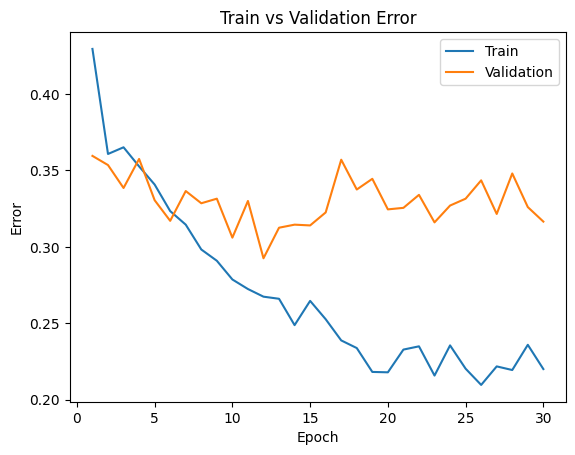

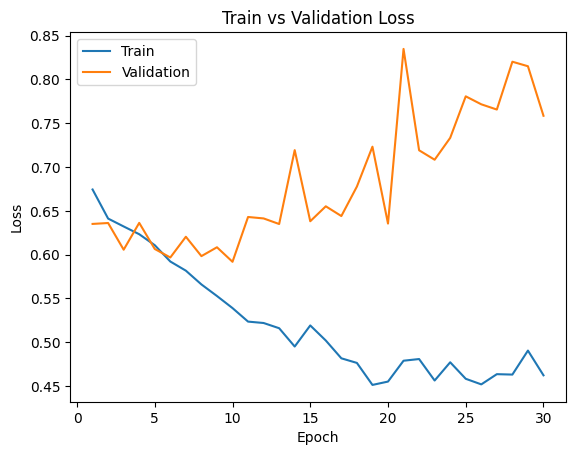

In [ ]:
large_net = LargeNet()
train_net(large_net, batch_size=64, learning_rate=0.1, num_epochs=30)
higher_lr_path = get_model_name("large",batch_size=64, learning_rate=0.1, epoch=29)
print("Higher Learning Rate Large Net (Error and  Loss): ")
plot_training_curve(higher_lr_path)


The model takes almost same amount to train (slightly longer)

 Default parameters: 172.52 seconds

 Current parameters: 174.00 seconds




Increasing learning rate:

Overfitting is introduced at even lower epochs  with the learning rate increased. The training loss decreases but validation loss increases starting from epoch 5. This shows that the model overfits the data from the early start, that too large of a step is unable to get to an optimal value for the weights. The change in loss or errors is also much more significant compared to the default learning rate of 0.01.


### Part (c) - 3pt

Train `large_net` with all default parameters, including with `learning_rate=0.01`.
Now, set `batch_size=512`. Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *increasing* the batch size.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.48175, Train loss: 0.6929379552602768 |Validation err: 0.478, Validation loss: 0.6926824003458023
Epoch 2: Train err: 0.457625, Train loss: 0.6924104057252407 |Validation err: 0.434, Validation loss: 0.6917425245046616
Epoch 3: Train err: 0.437, Train loss: 0.6916500627994537 |Validation err: 0.4265, Validation loss: 0.6909129917621613
Epoch 4: Train err: 0.433625, Train loss: 0.6908449903130531 |Validation err: 0.424, Validation loss: 0.6897870302200317
Epoch 5: Train err: 0.434, Train loss: 0.6896935515105724 |Validation err: 0.424, Validation loss: 0.6881355047225952
Epoch 6: Train err: 0.438, Train loss: 0.6883532106876373 |Validation err: 0.4285, Validation loss: 0.686011865735054
Epoch 7: Train err: 0.439375, Train loss: 0.6866871751844883 |Validation err: 0.426, Validation loss: 0.6836968660354614
Epoch 8: Train err: 0.43525, Train loss: 0.6849770732223988 |Validation err: 0.4115, V

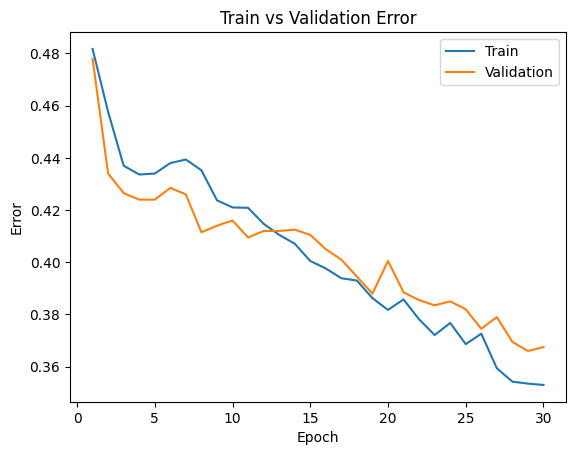

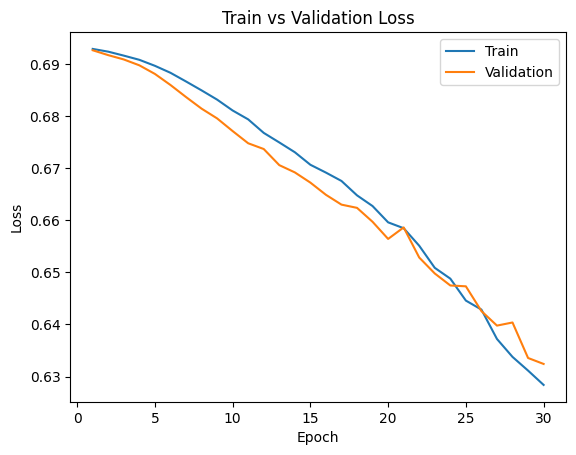

In [ ]:
large_net = LargeNet()

train_net(large_net, batch_size=512)
path = get_model_name("large",batch_size=512, learning_rate=0.01, epoch=29)
print("More Batches Large Net (Error and  Loss): ")
plot_training_curve(path)

Increasing the batch size allows multiple batches to be trained at once rather than only few batches at once. This might be why the trianing time has been greatly reduced to 135.32 seconds

The graph is underfitted since the coverging to optimal epoch is not seen and may be beyond 30 epochs. The larger set of images are used to train the images in each batch and calculate the appropriate weights for the larger subset of the dataset at once.The curves appear to more smooth and consistant since both validation and training curves are both decreasing.



### Part (d) - 3pt

Train `large_net` with all default parameters, including with `learning_rate=0.01`.
Now, set `batch_size=16`. Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *decreasing* the batch size.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.43175, Train loss: 0.6774994033575058 |Validation err: 0.382, Validation loss: 0.6513170146942139
Epoch 2: Train err: 0.369, Train loss: 0.6396398993134499 |Validation err: 0.3465, Validation loss: 0.6161113579273224
Epoch 3: Train err: 0.34375, Train loss: 0.6098222960829734 |Validation err: 0.3325, Validation loss: 0.6260210766792297
Epoch 4: Train err: 0.314375, Train loss: 0.584969149172306 |Validation err: 0.34, Validation loss: 0.6044013905525207
Epoch 5: Train err: 0.301125, Train loss: 0.5689119317531586 |Validation err: 0.3125, Validation loss: 0.5769183149337769
Epoch 6: Train err: 0.281, Train loss: 0.5452213580608368 |Validation err: 0.308, Validation loss: 0.570844743013382
Epoch 7: Train err: 0.270875, Train loss: 0.5272981309890747 |Validation err: 0.307, Validation loss: 0.5854293291568756
Epoch 8: Train err: 0.259375, Train loss: 0.507090549826622 |Validation err: 0.313, V

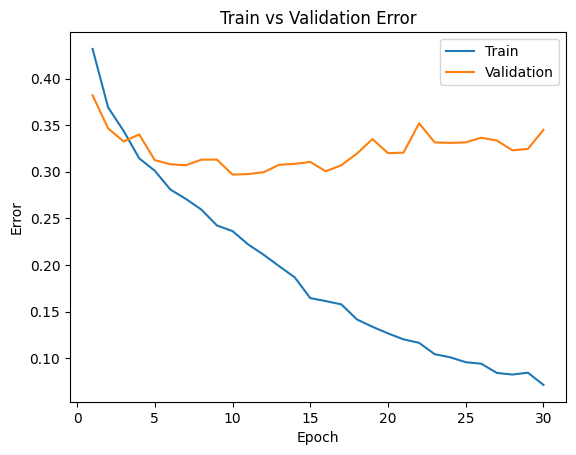

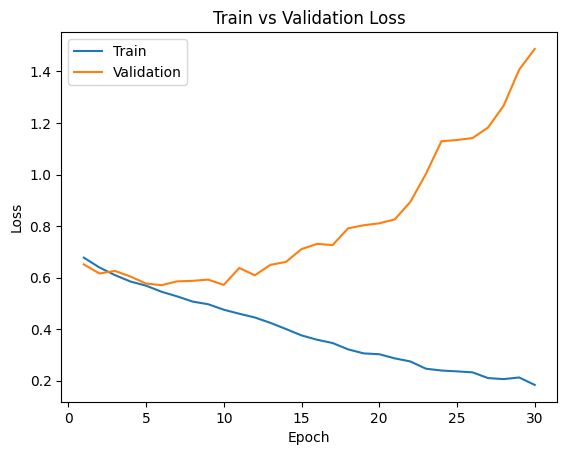

In [ ]:
large_net = LargeNet()

train_net(large_net, batch_size=16)
path = get_model_name("large",batch_size=16, learning_rate=0.01, epoch=29)
print("Less Batches Large Net (Error and  Loss): ")
plot_training_curve(path)


The batch size is reduced:

Training time increased to 221.39 seconds.
Weights might be needed to be updated frequently and since smaller batches are processed at one time, the data is not able to perform as well on unseen validation data since it hasn't been more generalized.
Training error/loss is decreasing with validation error/loss only up to epoch 5. But after epoch 5, the data is overfitted since validation error/loss starts to increase and move away from training curve.

## Part 4. Hyperparameter Search [6 pt]

### Part (a) - 2pt

Based on the plots from above, choose another set of values for the hyperparameters (network, batch_size, learning_rate)
that you think would help you improve the validation accuracy. Justify your choice.

To improve the Validation accuracy, the non-overfitted models should be considered at higher epochs (instead of choosing overfitted models at lower epochs) since the model will be able to perform better on new data.

The learning_rate of 0.001, the batch size of 512 would help improve validation accuracy (reducing overfitting) but from the graphs, the model appears to be underfit.

Large_net is the network that should be used instead of small net because of further feature extraction is involved in more convolution layers/ more filtering done.

If only 30 epochs were used, the model would underfit; to achieve the maximum performance (lowest validation loss/error), the number of epochs should be increased greatly to about 350



### Part (b) - 1pt

Train the model with the hyperparameters you chose in part(a), and include the training curve.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.48825, Train loss: 0.6930677555501461 |Validation err: 0.4955, Validation loss: 0.6931361854076385
Epoch 2: Train err: 0.483125, Train loss: 0.692995510995388 |Validation err: 0.4945, Validation loss: 0.6930360347032547
Epoch 3: Train err: 0.480375, Train loss: 0.6929280385375023 |Validation err: 0.493, Validation loss: 0.6929539740085602
Epoch 4: Train err: 0.477, Train loss: 0.6928808502852917 |Validation err: 0.4885, Validation loss: 0.692870706319809
Epoch 5: Train err: 0.473375, Train loss: 0.6927744261920452 |Validation err: 0.4835, Validation loss: 0.6927504986524582
Epoch 6: Train err: 0.469, Train loss: 0.6926896274089813 |Validation err: 0.472, Validation loss: 0.6926551908254623
Epoch 7: Train err: 0.46325, Train loss: 0.692620363086462 |Validation err: 0.47, Validation loss: 0.6925524920225143
Epoch 8: Train err: 0.46225, Train loss: 0.6925435587763786 |Validation err: 0.463, V

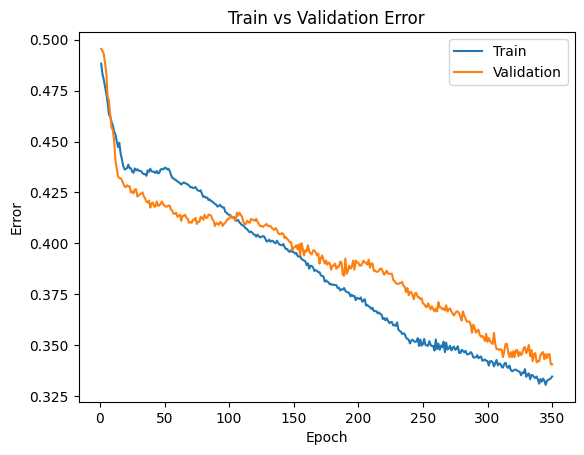

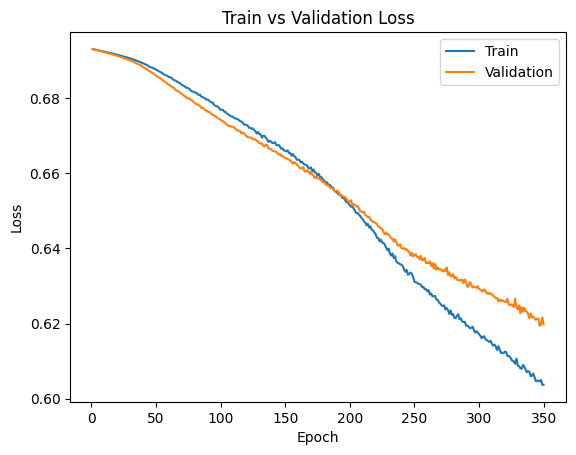

In [ ]:
large_net = LargeNet()
train_net(large_net, batch_size=512, learning_rate=0.001, num_epochs=350)
model_path = get_model_name("large", batch_size=512, learning_rate=0.001, epoch=349)
plot_training_curve(model_path)

### Part (c) - 2pt

Based on your result from Part(a), suggest another set of hyperparameter values to try.
Justify your choice.

Based on the results from part (a), another set of hyperparamters might include increasing the learning rate by only a little bit so that larger "steps" are taken in current number of epochs given (since the training time took very long).

The validation loss/error seems to keep decreasing so more epochs might be needed (method 1) or lower epochs + learning rate increase (method 2).

In method 1:
Alternatively, if the learning rate was kept at 0.001, then to find the point where validation loss/error starts to increase (optimal stopping point), one may decide to increase the current number of epochs to find the optimal stopping point.

Choosing Method 2 so the new hyperparameters:
learning_rate = 0.01  instead of 0.001
num_epochs = 55 instead of 350 (lowering the epochs since the step size is now increased)


### Part (d) - 1pt

Train the model with the hyperparameters you chose in part(c), and include the training curve.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.50225, Train loss: 0.694217212498188 |Validation err: 0.4915, Validation loss: 0.6921818256378174
Epoch 2: Train err: 0.500625, Train loss: 0.6921459548175335 |Validation err: 0.481, Validation loss: 0.6905356794595718
Epoch 3: Train err: 0.459875, Train loss: 0.6904373988509178 |Validation err: 0.4265, Validation loss: 0.6887338012456894
Epoch 4: Train err: 0.4355, Train loss: 0.6886366829276085 |Validation err: 0.422, Validation loss: 0.6861189007759094
Epoch 5: Train err: 0.43525, Train loss: 0.6861504092812538 |Validation err: 0.416, Validation loss: 0.68313267827034
Epoch 6: Train err: 0.432625, Train loss: 0.6838141903281212 |Validation err: 0.418, Validation loss: 0.6799432635307312
Epoch 7: Train err: 0.42975, Train loss: 0.6808573193848133 |Validation err: 0.4085, Validation loss: 0.6771533936262131
Epoch 8: Train err: 0.422125, Train loss: 0.6779023110866547 |Validation err: 0.41

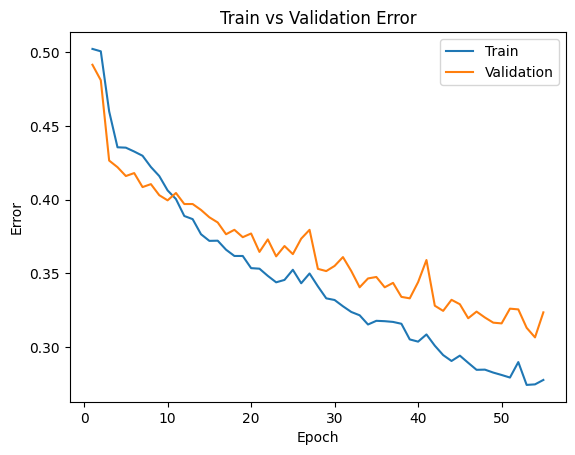

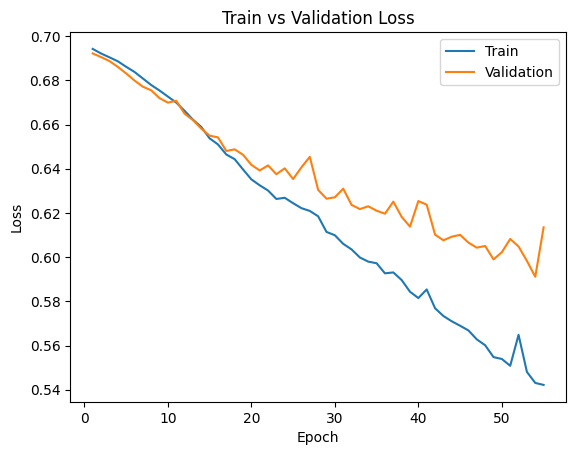

In [ ]:
large_net = LargeNet()
train_net(large_net, learning_rate = 0.01, batch_size = 512, num_epochs = 55)

large_model_path = get_model_name("large", batch_size=512, learning_rate=0.01, epoch=54)
plot_training_curve(large_model_path)

## Part 4. Evaluating the Best Model [15 pt]


### Part (a) - 1pt

Choose the **best** model that you have so far. This means choosing the best model checkpoint,
including the choice of `small_net` vs `large_net`, the `batch_size`, `learning_rate`,
**and the epoch number**.

Modify the code below to load your chosen set of weights to the model object `net`.

In [ ]:
net = LargeNet()
model_path = get_model_name(net.name, batch_size=512, learning_rate=0.01, epoch=54)
state = torch.load(model_path)
net.load_state_dict(state)

<All keys matched successfully>

The model that is used: large_net, batch_size = 512, learning_rate = 0.01, and epoch = 54.


### Part (b) - 2pt

Justify your choice of model from part (a).

Larger Batch size of 512 helped in reduce overfitting of the model, and helped in speeding up the training time.

The learning rate of 0.01 helped take medium steps (to balance between time to train efficiency and to not overfit). Optimal steps to reach the best performance of the model.
The epoch number was chosen based on when the validation loss/error started to plateau and not increase further when tested with 70 =num_epochs, so 55 = num_epochs were chosen. This ensured that the model was neither underfit nor overfit.

LargeNet was chosen since it had more layers/ filtering than small_net

### Part (c) - 2pt

Using the code in Part 0, any code from lecture notes, or any code that you write,
compute and report the **test classification error** for your chosen model.

In [ ]:
# If you use the `evaluate` function provided in part 0, you will need to
# set batch_size > 1

'''
def evaluate(net, loader, criterion):
    """ Evaluate the network on the validation set.

     Args:
         net: PyTorch neural network object
         loader: PyTorch data loader for the validation set
         criterion: The loss function
     Returns:
         err: A scalar for the avg classification error over the validation set
         loss: A scalar for the average loss function over the validation set
     """
'''
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"],
    batch_size=512)
#         criterion: The loss function
lossFunction = nn.BCEWithLogitsLoss() #SigmoidActivation function + BinaryCrossEntropyLoss
testingErr, testingLoss = evaluate(net,test_loader,lossFunction)
validationError, validationLoss = evaluate(net,val_loader,lossFunction)

print("test classification error: ", testingErr)
print("test classification loss: ", testingLoss)

print("validation error: ", validationError)
print("validation loss: ", validationLoss)


Files already downloaded and verified
Files already downloaded and verified
test classification error:  0.311
test classification loss:  0.5917133539915085
validation error:  0.3235
validation loss:  0.6133498251438141


The test classification Error : 0.311
Validation Error: 0.3235

### Part (d) - 3pt

How does the test classification error compare with the **validation error**?
Explain why you would expect the test error to be *higher* than the validation error.

The test classification error should ideally be higher than the validation classification error but in this case, the validation error was about 0.3235 and the test classification error was 0.311 (very similar). This might have happened maybe due to similarties in the test or validation sets.





The test error would be expected to be higher than the validation error because during the hyper-tuning stages, the hyperparamters were tuned according to reduce validation error/losses. So even if the validation sets were unseen data, it would perform better since the validation error/loss had been used to choose the model. However, for the test sets, the data is completely new and the model is not specifically trained to minimize the loss/error of the test sets. If the trained model is well at peforming in the test set, then the hyperparameters that were chosen were appropriate assuming that the training, validation ,and test sets had distinct data images (not similar to each other).

### Part (e) - 2pt

Why did we only use the test data set at the very end?
Why is it important that we use the test data as little as possible?

We only use test data set at the very end so that the model does not try to memorize or overfit the testing data. If that happens, then the dataset would be completely memorized by the model and one would be unable to evaluate the model on real-world data (actual, unseen data). The test data should be used as little as possible which is why it was used at the very end to ensure that the estimates of the errors one gets are unbiased. Using the testing dataset, one may be better able to predict how well the model performs on new data and the reliability of the model/error reports.

### Part (f) - 5pt

How does the your best CNN model compare with an 2-layer ANN model (no convolutional layers) on classifying cat and dog images. You can use a 2-layer ANN architecture similar to what you used in Lab 1. You should explore different hyperparameter settings to determine how well you can do on the validation dataset. Once satisified with the performance, you may test it out on the test data.

Hint: The ANN in lab 1 was applied on greyscale images. The cat and dog images are colour (RGB) and so you will need to flatted and concatinate all three colour layers before feeding them into an ANN.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt # for plotting
import torch.optim as optim

torch.manual_seed(1) # set the random seed

# define a 2-layer artificial neural network

class ANNWithColourImages(nn.Module):
   def __init__(self):
      super(ANNWithColourImages,self).__init__()
      self.name = "ANNWithColourImages"
      # depth*height*width of image is input (3*32*32) (32x32 is h and w of the CIFAR dataset), 30 hidden neurons or units
      self.layer1 = nn.Linear(3*32*32,30)
      self.layer2 = nn.Linear(30,1)

   def forward(self, img):
      flattened = img.view(-1, 3*32*32) # flatten the RGB channels for 3 dimension image
      #flattend is a 1d Array [batch_size, 3*32*32 ]
      #[batch_size,30] is the tensor size after layer 1 + activation
      #[batch_size,1] is the tensor size after layer 2

      activation1 = self.layer1(flattened)
      activation1 = F.relu(activation1)
      activation2 = self.layer2(activation1)

      # with .Squeeze just want [batch_size] , remove the uneeded dimension so all tensor is
      #[1, 2, 3] instead of a vector of tensors

      result = activation2.squeeze(1)
      #target size (torch.Size([512])) must be the same as input size
      # (torch.Size([512, 1]))
      return result

modelANN = ANNWithColourImages()



In [ ]:
# train and test the ANN model

train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"],
    batch_size=512)
#After using different hyperparameters for batch_size etc. these were the best ones

train_net(modelANN, batch_size=512, learning_rate= 0.01, num_epochs = 55)

lossFunction = nn.BCEWithLogitsLoss()

testingError, testingLoss = evaluate(modelANN, test_loader, lossFunction)
print("testing ANN error", testingError)
valError, valLoss = evaluate(modelANN, val_loader, lossFunction)
print("validation ANN error:", valError)

100%|██████████| 170498071/170498071 [00:03<00:00, 47762915.08it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.43975, Train loss: 0.6805083453655243 |Validation err: 0.415, Validation loss: 0.6669475883245468
Epoch 2: Train err: 0.39925, Train loss: 0.6614224947988987 |Validation err: 0.396, Validation loss: 0.6568853408098221
Epoch 3: Train err: 0.383375, Train loss: 0.650784008204937 |Validation err: 0.391, Validation loss: 0.6542761474847794
Epoch 4: Train err: 0.37725, Train loss: 0.6439845263957977 |Validation err: 0.385, Validation loss: 0.6506889909505844
Epoch 5: Train err: 0.36825, Train loss: 0.6377266049385071 |Validation err: 0.3845, Validation loss: 0.6488837003707886
Epoch 6: Train err: 0.3635, Train loss: 0.6337844878435135 |Validation err: 0.3845, Validation loss: 0.6490282565355301
Epoch 7: Train err: 0.3605, Train loss: 0.6297933012247086 |Validation err: 0.3875, Validation loss: 0.64789488911

The CNN performs better than the ANN (testing error for the ANN is 0.3585 vs CNN testing error is 0.311).For an image, the spatial reference of how the objects in the images are located is lost when everything is flattened into a 1D array in ANNs. The CNNs with their kernals preserve the image's key features and work best for images; if slightly different hyperparameters were chosen, then the CNN would perform even better. Learning the kernal weights ensures that the best features are extracted - which is done by CNNs efficiently.